# 10. Spore Clusters

## Numerical experiments - Week 08/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
using PyPlot
using Revise
using CurveFit

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting

## 1. Spore centroid generation

The following code computes the coordinates of a cluster of $n$ spherical spores, placing one spore at the centre of the lattice and the rest of the spores distributed evenly around it - in polar, triangular, tetrahedral, cubic, octahedral and icosahedral configurations.

In [2]:
spore_diameter = 5.0
spore_rad = spore_diameter / 2.0

L=25.0

spore_centers = setup_spore_cluster(12, L, spore_rad)

13-element Vector{Tuple{Float64, Float64, Float64}}:
 (12.5, 12.5, 12.5)
 (12.5, 9.871344439404332, 16.7532540417602)
 (12.5, 9.871344439404332, 8.2467459582398)
 (12.5, 15.128655560595668, 8.2467459582398)
 (16.7532540417602, 12.5, 15.128655560595668)
 (16.7532540417602, 12.5, 9.871344439404332)
 (8.2467459582398, 12.5, 9.871344439404332)
 (8.2467459582398, 12.5, 15.128655560595668)
 (15.128655560595668, 16.7532540417602, 12.5)
 (9.871344439404332, 16.7532540417602, 12.5)
 (9.871344439404332, 8.2467459582398, 12.5)
 (15.128655560595668, 8.2467459582398, 12.5)
 (12.5, 15.128655560595668, 16.7532540417602)

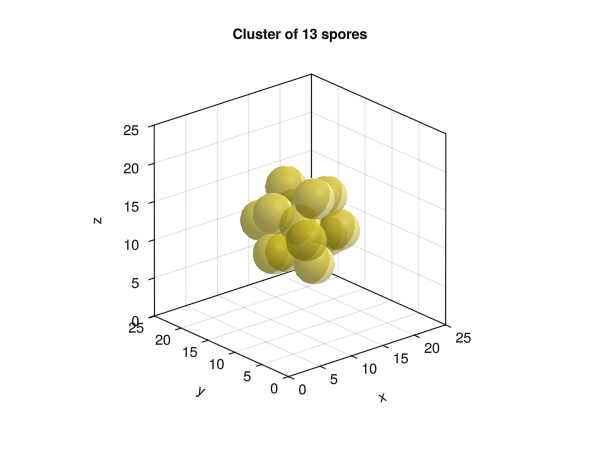

Makie.Axis3()

In [3]:
plot_spheres!(spore_centers, spore_rad, L, inline=true, title="Cluster of $(size(spore_centers)[1]) spores")

## 2. Measure of spore exposure

To measure the degree of coverage of a spore, a geometric construction is used that projects the areas of the surrounding spheres onto the central spore surface, here denoted as the sampling sphere, or sphere A. Let sphere B be a second reference sphere, with a centre positioned at a distance $d$ from the sampling sphere. One can construct a cone with a tip at the centre of the sphere A that touches sphere B tangentially. It thus intersects sphere A at a circular region, forming a spherical cap. The area of this cap can be computed by an integral over polar coordinates with a reference to the axis connecting the cenres of the two spheres:

$$
\begin{equation}
A=R^2\int_0^{2\pi}{\int_0^{\phi_0}{\sin{\phi}d{\phi}}d{\theta}},
\end{equation}
$$

where $\phi_0$ is the half-angle at the tip of the cone and defines the maximum that the vertical angle $\phi$ can reach and $\theta$ is the azimuthal angle around the reference axis. It can be noted that the farther sphere B is, the smaller its projection represented through the cap area would be. One can think of this projection as the "shadow" of sphere B onto sphere A. To capture even more detail about the proximity of surrounding spheres to the sampling sphere, each infinitesimal unit of area can be weighted by a function that depends on the projection distance between the surface areas. This can be pictured as the distance between two intersection points of a ray emanating from the centre of sphere A toward the sampled infinitesimal volume - one intersection through the surface of A and one through the surface of B. This distance can be expressed through the formula

$$
\begin{equation}
\Delta=d\cos{\phi}-\sqrt{R^2-d^2\sin^2{\phi}}-R
\end{equation}
$$

and used in a weighting function $w{(\phi)}=e^{-\Delta{(\phi)}}$, such that a weighted cap area is attained:

$$
\begin{equation}
A_w=R^2\int_0^{2\pi}{\int_0^{\phi_0}{e^{-\Delta{(\phi)}}\sin{\phi}d{\phi}}d{\theta}}.
\end{equation}
$$

This has the property that the "shadow" intensity becomes 1 at $\Delta=0$ and decays to zero with increasing distance. Since the integrand is independent of the azimuthal angle $\theta$, the integral simplifies to

$$
\begin{equation}
A_w=2\pi R^2\int_0^{\phi_0}{e^{-\Delta{(\phi)}}\sin{\phi}d{\phi}}.
\end{equation}
$$

The maximum limit for $\phi$ can be computed as $\phi_0=\arcsin{\frac{R}{d}}$. Thus, writing out the complete integral and summing for $M$ neighbours, one can obtain a measure for the surface coverage of a spore:

$$
\begin{equation}
Q=2\pi R^2\sum_i^M\int_0^{\arcsin{\frac{R}{d_i}}}{\exp{\left[d_i\cos{\phi}-\sqrt{R^2-d_i^2\sin^2{\phi}}-R\right]}\sin{\phi}d{\phi}},
\end{equation}
$$

where $d_i$ are the corresponding distances from the sampling sphere centre to the neighbour centres. Furthermore, the cumulative surface coverage can be made relative to the total surface area of the spore by dividing by $4\pi R^2$:

$$
\begin{equation}
Q=\frac{1}{2}\sum_i^M\int_0^{\arcsin{\frac{R}{d_i}}}{\exp{\left[d_i\cos{\phi}-\sqrt{R^2-d_i^2\sin^2{\phi}}-R\right]}\sin{\phi}d{\phi}}.
\end{equation}
$$

It is hereby assumed that only spheres that have an unobstructed "field of view" from the sampling sphere are considered. In the current experiments, these are furthermore only spheres that are directly adjacent to the central sphere.

The measure of coverage $Q$ is computed using the Julia `QuadGK` package and is demonstrated for different neighbour configurations.

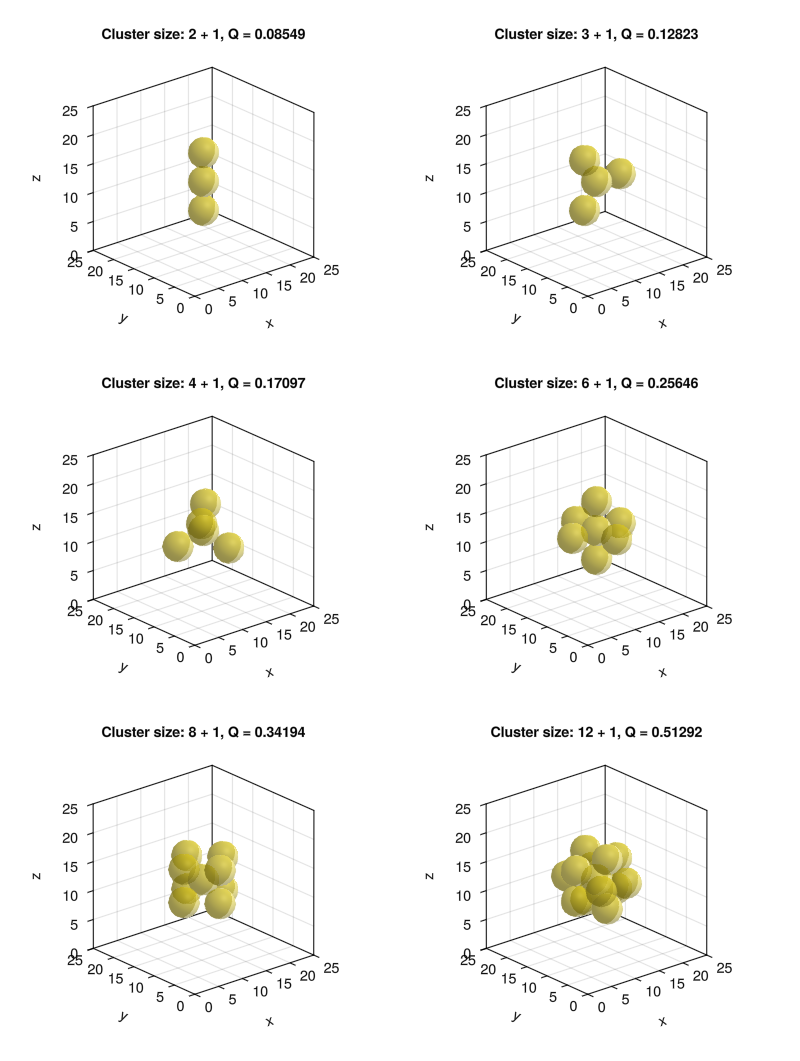

GLMakie.Screen(...)

In [67]:
spore_diameter = 5.0
spore_rad = spore_diameter / 2.0

L=25.0

n_nbrs = [2, 3, 4, 6, 8, 12]

plot_spore_clusters(n_nbrs, spore_rad, L)

Apart from the fully symmetrical neighbour configurations, asymmetrical arrangements of the spores are also investigated by omitting all spores in the upper half-space of the cluster. Apart from implementing neighbourhood counts which were not possible in the regular clusters, this is helpful for verifying whether the same number of neighbours in a symmetrical and an asymmetrical arrangement has the same influence on diffusion inhibition.

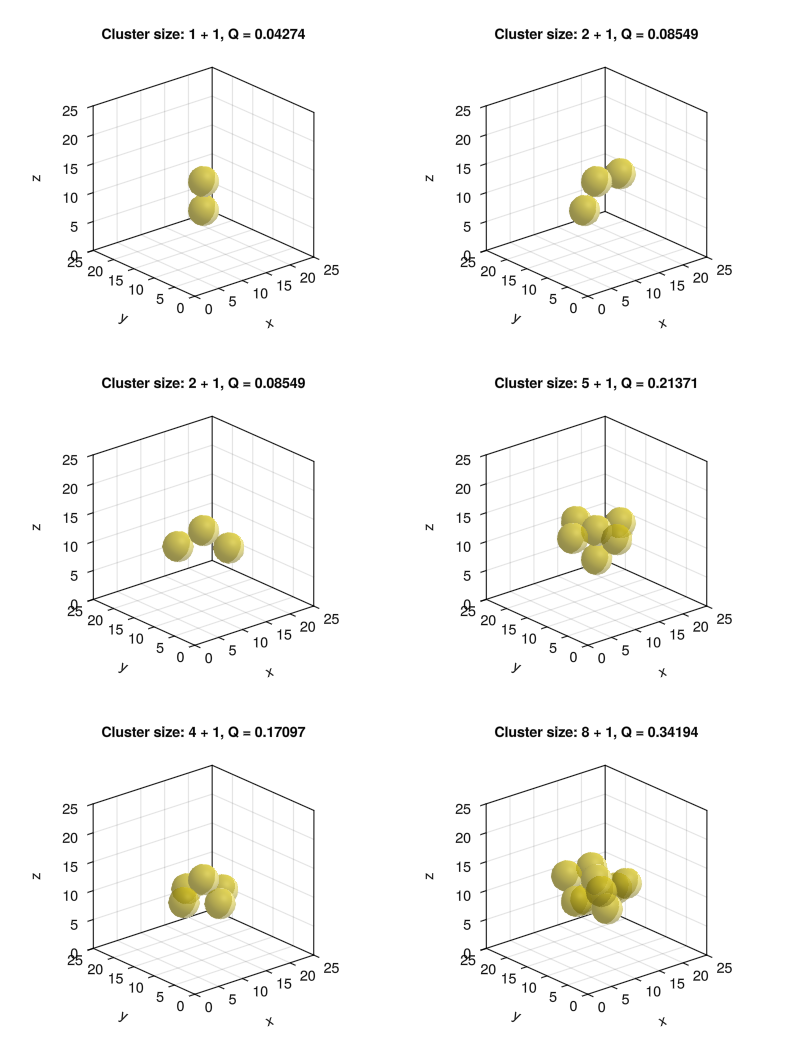

GLMakie.Screen(...)

In [68]:
plot_spore_clusters(n_nbrs, spore_rad, L; cut_half=true)

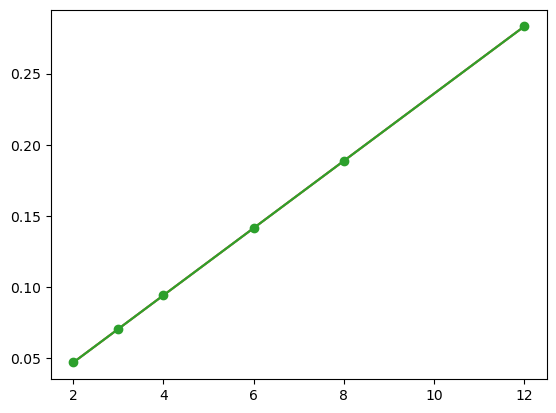

In [15]:
plot([2,3,4,6,8,12],[0.04717,0.07075,0.09434,0.1415,0.18867,0.28301], marker="o")
gcf()

## 3. Diffusion test

A diffusion process in a multi-spore cluster is briefly demonstrated in a linear cluster of 3 for a time-frame of 100 seconds. An absorbing boundary condition is defined, such that the concentrations at the edges of the domain are always zero. The lattice size is set to $128\times 0.2\mu m$.

In [69]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 100 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# Diffusion parameters
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

# Spore centers
sp_cen_indices = setup_spore_cluster(2, N, spore_rad / dx + 0.5, false) # with safety radius of 0.5

# Run simulation
n_save_frames = 100
c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true)
println("Numerical solution (high-resolution): ", c_numerical[end])

Using D = 600, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 6.688382673779544e-5, Dcw*dt/dx2 = 3.344191486004655e-5
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
3.8399999141693115
Frame 1 saved.
3.839613437652588
Frame 2 saved.
3.8392281532287598
Frame 3 saved.
3.838844060897827
Frame 4 saved.
3.838458776473999
Frame 5 saved.
3.8380725383758545
Frame 6 saved.
3.837686061859131
Frame 7 saved.
3.83729887008667
Frame 8 saved.
3.8369128704071045
Frame 9 saved.
3.8365280628204346
Frame 10 saved.
3.8361427783966064
Frame 11 saved.
3.835756778717041
Frame 12 saved.
3.8353724479675293
Frame 13 saved.
3.8349883556365967
Frame 14 saved.
3.8346025943756104
Frame 15 saved.
3.834218740463257
Frame 16 saved.
3.8338348865509033
Frame 17 saved.
3.8334505558013916
Frame 18 saved.
3.8330657482147217
Frame 19 saved.
3.8326807022094727
Frame 20 saved.
3.8322973251342773
Frame 21 saved.
3.83191

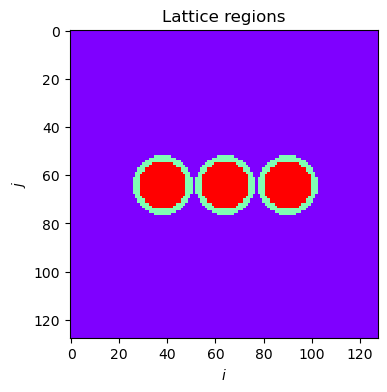

In [70]:
plot_lattice_regions(region_ids)

Plotting frames: [1, 26, 51, 76]


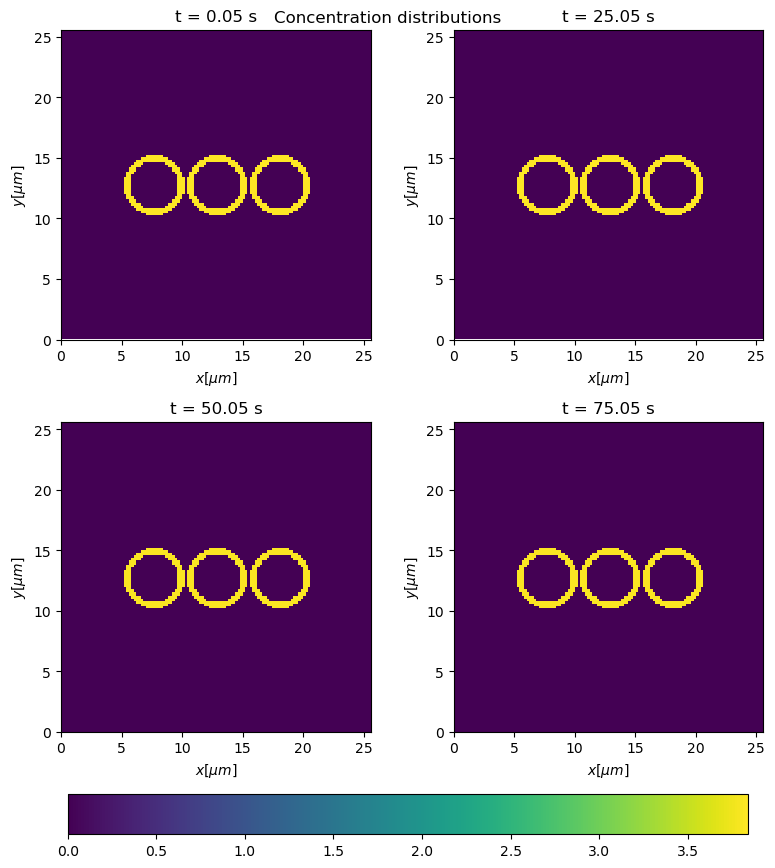

In [71]:
frame_indices = collect(1:round(Int, size(c_frames)[1] / 4):size(c_frames)[1]-1)
plot_concentration_lattice(c_frames, dx, frame_indices=frame_indices, times=times_numerical, title="Concentration distributions")

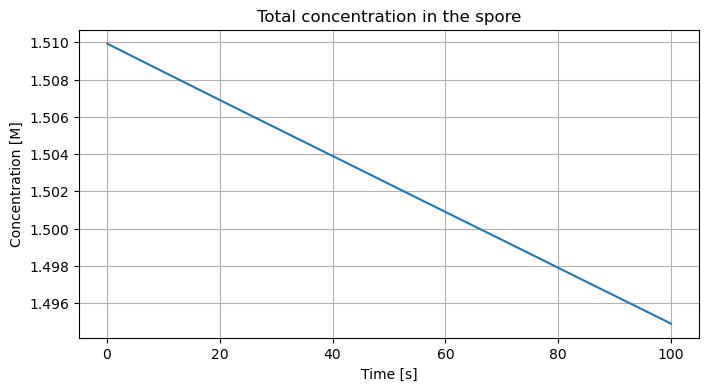

In [72]:
plot_concentration_evolution(c_numerical, times_numerical)

## 4. Diffusion experiments with two extremes

### 4.1. Slow release

To establish whether the spore coverage has any significant effect on the diffusion of the inhibitor, the two extreme configurations: a single spore and a fully surrounded spore with 12 neighbours, are used in a high-resolution diffusion simulation. The usual time-frame of 4 hours is used.

In [73]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# ===== Single spore simulation =====
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames_ss, c_numerical_ss, times_numerical_ss, region_ids_ss, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, [spore_center_idx], spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true)
println("Numerical solution single spore: ", c_numerical_ss[end])

# ===== Dense cluster simulation =====
sp_cen_indices = setup_spore_cluster(12, N, spore_rad / dx + 0.5, false)  # with safety radius of 0.5
c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true)
println("Numerical solution single spore: ", c_numerical_ms[end])

Using D = 600, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 6.688382673779544e-5, Dcw*dt/dx2 = 3.344191486004655e-5
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
3.8399999141693115
Frame 1 saved.
3.677431106567383
Frame 2 saved.
3.521779775619507
Frame 3 saved.
3.372706174850464
Frame 4 saved.
3.229940176010132
Frame 5 saved.
3.0931899547576904
Frame 6 saved.
2.962285280227661
Frame 7 saved.
2.8368866443634033
Frame 8 saved.
2.716817617416382
Frame 9 saved.
2.6018121242523193
Frame 10 saved.
2.4916739463806152
Frame 11 saved.
2.386207342147827
Frame 12 saved.
2.285219430923462
Frame 13 saved.
2.1884663105010986
Frame 14 saved.
2.0958123207092285
Frame 15 saved.
2.0071120262145996
Frame 16 saved.
1.9221481084823608
Frame 17 saved.
1.84079110622406
Frame 18 saved.
1.7628761529922485
Frame 19 saved.
1.68825101852417
Frame 20 saved.
1.6167899370193481
Frame 21 saved.
1.548340559

Plotting frames: [26, 51, 76, 101]


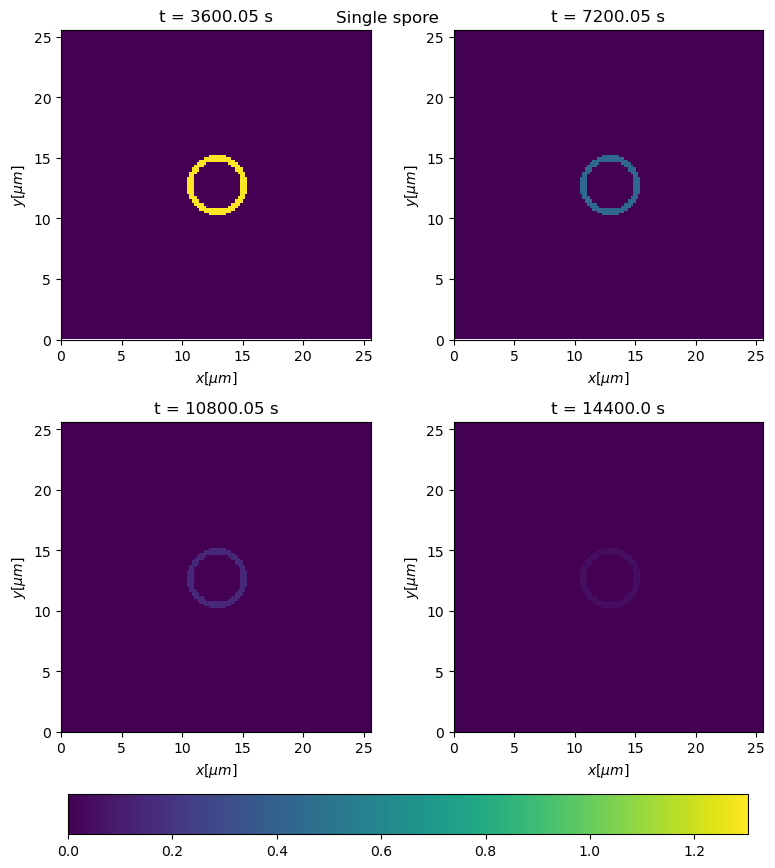

In [76]:
frame_indices = collect(round(Int, size(c_frames_ss)[1] / 4):round(Int, size(c_frames_ss)[1] / 4):size(c_frames_ss)[1]+1).+1
plot_concentration_lattice(c_frames_ss, dx, frame_indices=frame_indices, times=times_numerical_ss, title="Single spore")

[25, 50, 75, 100]
Plotting frames: [26, 51, 76, 101]


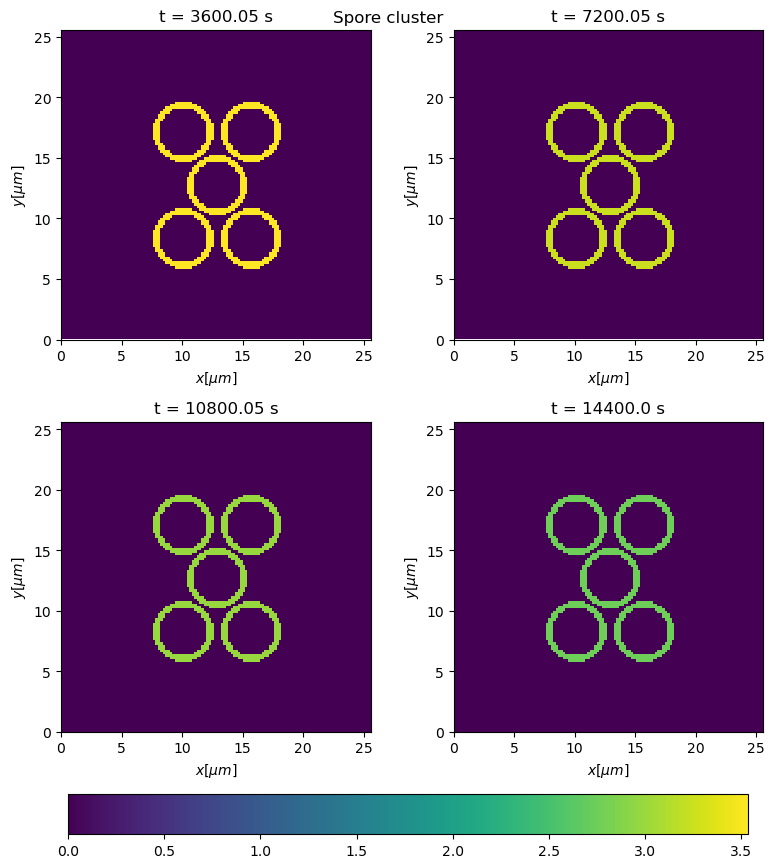

In [77]:
frame_indices = collect(round(Int, size(c_frames_ms)[1] / 4):round(Int, size(c_frames_ms)[1] / 4):size(c_frames_ms)[1]+1).+1
println(frame_indices.-1)
plot_concentration_lattice(c_frames_ms, dx, frame_indices=frame_indices, times=times_numerical_ms, title="Spore cluster")

Single spore
Fitted exponential: (1.5099387885239886, -0.00030035629066141393)
Dense cluster
Fitted exponential: (1.5098730952376938, -2.3092081377804166e-5)


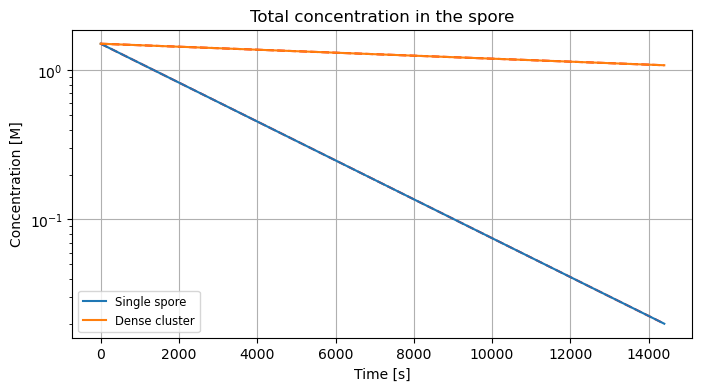

In [78]:
compare_concentration_evolutions([c_numerical_ss, c_numerical_ms], [times_numerical_ss, times_numerical_ms], ["Single spore", "Dense cluster"]; logy=true, fit_exp=true)

The much slower decay of the concentration in the central spore of the dense cluster indicates that the obstacles imposed by the surrounding spores have a significant effect on the depletion of the inhibitor.

### 4.2. Fast release

A relevant control experiment that can elucidate the role of spatial obstacles around the spore is to conduct analogical tests with disregard of the slow release, i.e. using the same diffusion coefficient within the medium and inside the cell wall. Since the absorbing boundary prohibits any finite-size saturation effects, a lingering concentration in the spore would indicate that the impermeable spore interiors have a severe limiting effect on the escape of inhibitor molecules. As the inhibitor of the uncovered spore is expected to diffuse fast, a time-frame of 1 second is observed.

In [83]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 1##14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.00001
Db = D # same as diffusion through medium
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# ===== Single spore simulation =====
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
# c_frames_ss, c_numerical_ss, times_numerical_ss, region_ids_ss, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, [spore_center_idx], spore_diameter / 2, t_max;
#                                                                         D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true)
c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res!(copy(c_init), c0_cw, [spore_center_idx], spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, abs_bndry=true)
println("Numerical solution single spore: ", c_numerical_ss[end])

# ===== Dense cluster simulation =====
sp_cen_indices = setup_spore_cluster(12, N, spore_rad / dx + 0.5, false)  # with safety radius of 0.5
# c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_diameter / 2, t_max;
#                                                                         D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=true, abs_bndry=false)
c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res!(copy(c_init), c0_cw, sp_cen_indices, spore_diameter / 2, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, abs_bndry=true)
println("Numerical solution single spore: ", c_numerical_ms[end])

Using D = 600, Db = 600, Dcw = 600.0
D*dt/dx2 = 0.14999999999999997, Db*dt/dx2 = 0.14999999999999997, Dcw*dt/dx2 = 0.14999999999999997
Spore radius in lattice units: 12.5
Concentrations initialised.
Ideal cell wall volume: 26.657460863260585
Discretised cell wall volume: 32.62400000000001
Ideal spore volume: 65.44984694978736
Discretised spore volume: 65.73600000000002
Storage arrays allocated.
Frame 1 saved.
Frame 2 saved.
Frame 3 saved.
Frame 4 saved.
Frame 5 saved.
Frame 6 saved.
Frame 7 saved.
Frame 8 saved.
Frame 9 saved.
Frame 10 saved.
Frame 11 saved.
Frame 12 saved.
Frame 13 saved.
Frame 14 saved.
Frame 15 saved.
Frame 16 saved.
Frame 17 saved.
Frame 18 saved.
Frame 19 saved.
Frame 20 saved.
Frame 21 saved.
Frame 22 saved.
Frame 23 saved.
Frame 24 saved.
Frame 25 saved.
Frame 26 saved.
Frame 27 saved.
Frame 28 saved.
Frame 29 saved.
Frame 30 saved.
Frame 31 saved.
Frame 32 saved.
Frame 33 saved.
Frame 34 saved.
Frame 35 saved.
Frame 36 saved.
Frame 37 saved.
Frame 38 saved.
Fra

Plotting frames: [1, 2, 67, 101]


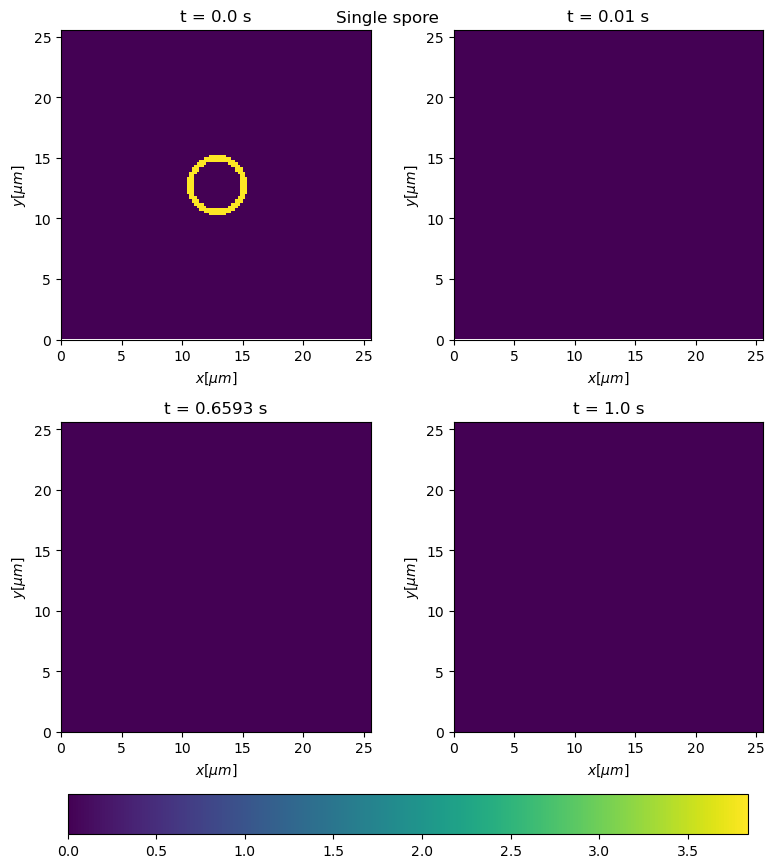

In [85]:
frame_indices = collect(round(Int, size(c_frames_ss)[1] / 3):round(Int, size(c_frames_ss)[1] / 3):size(c_frames_ss)[1]+1).-1
frame_indices[1] = 2
frame_indices = [1; frame_indices]
plot_concentration_lattice(c_frames_ss, dx, frame_indices=frame_indices, times=times_numerical_ss, title="Single spore")

Plotting frames: [1, 2, 67, 101]


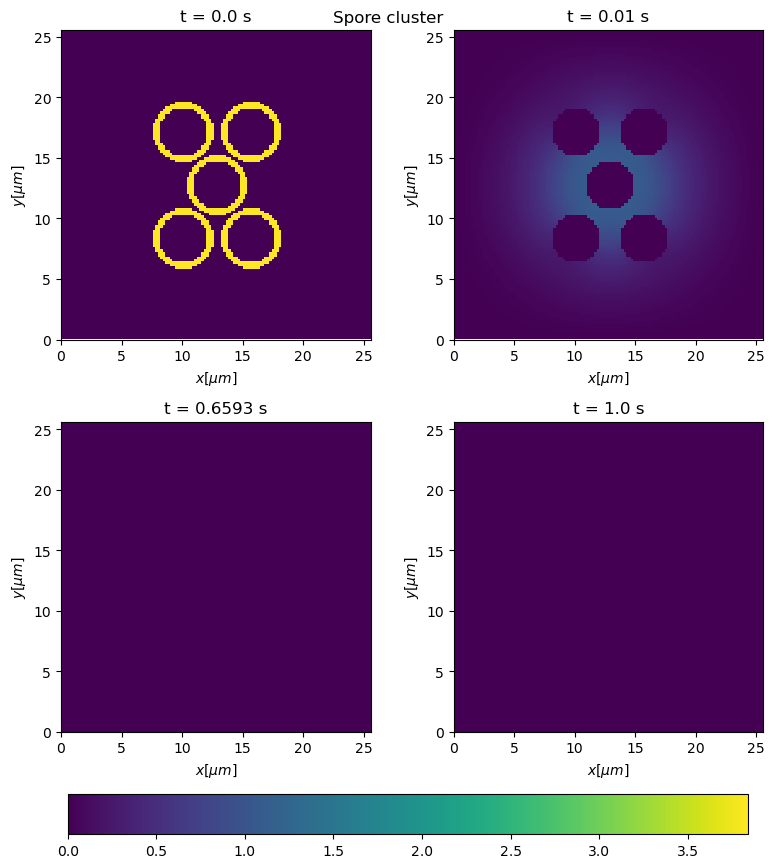

In [86]:
frame_indices = collect(round(Int, size(c_frames_ms)[1] / 3):round(Int, size(c_frames_ms)[1] / 3):size(c_frames_ms)[1]+1).-1
frame_indices[1] = 2
frame_indices = [1; frame_indices]
plot_concentration_lattice(c_frames_ms, dx, frame_indices=frame_indices, times=times_numerical_ms, title="Spore cluster")

Single spore
Dense cluster


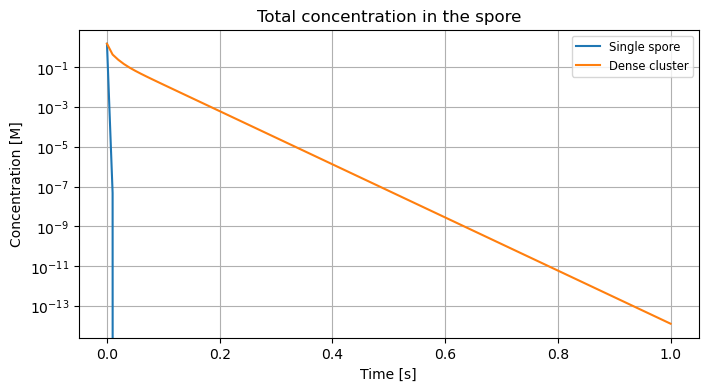

In [88]:
compare_concentration_evolutions([c_numerical_ss, c_numerical_ms], [times_numerical_ss, times_numerical_ms], ["Single spore", "Dense cluster"]; logy=true, fit_exp=false)

The results indicate that while the dense cluster significantly slows down diffusion compared to the instantaneous decay of the single spore, no concentration becomes permanently trapped between the spores.

## 5. Invariance of neighbour positions

Since the coverage measure is independent of the ordering the neighbours around the central sphere, it is important to ascertain whether asymmetrical configurations have the same effect on the decay of spore concentrations as symmetrical ones with the same cluster size. Several comparisons are made:
- a linear array of 3 spores vs. triangular arrays resulting from a trimmed 4-spore cluster and a trimmed 5-spore tetrahedron;
- a tetrahedral array of 5 spores vs. a trimmed 9-spore cubic cluster;
- a cubic array of 9 spores vs. a trimmed 13-spore icosahedral cluster.

In [ ]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# Simulation parameters (neighbours, trim)
param_groups = [[(2, false), (3, true), (4, true)],
                [(4, false), (8, true)],
                [(8, false), (12, true)]]

c_groups = []
times_groups = []
# coverage_groups = []
for params in param_groups
    c_group = []
    times_group = []
    # coverage_group = []
    for (n_nbrs, trim) in params
        println("Running simulation with $(n_nbrs) neighbours and trim: $(trim)")
        sp_cen_indices = setup_spore_cluster(n_nbrs, N, spore_rad / dx + 0.5, trim) # with safety radius of 0.5
        sp_cen_coords = [(i[1] * dx, i[2] * dx, i[3] * dx) for i in sp_cen_indices]
        c_frames_ms, c_numerical_ms, times_numerical_ms, region_ids_ms, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_rad, t_max;
                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false, abs_bndry=true)
        push!(c_group, vec(c_numerical_ms))
        push!(times_group, vec(times_numerical_ms))
        # push!(coverage_group, measure_coverage(sp_cen_coords[1], sp_cen_coords[2:end], spore_rad))
    end
    push!(c_groups, c_group)
    push!(times_groups, times_group)
    # push!(coverage_groups, coverage_group)
end

Running simulation with 2 neighbours and trim: false
Using D = 600, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 6.688382673779544e-5, Dcw*dt/dx2 = 3.344191486004655e-5
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
Frame 1 saved.
Frame 2 saved.
Frame 3 saved.
Frame 4 saved.
Frame 5 saved.
Frame 6 saved.
Frame 7 saved.
Frame 8 saved.
Frame 9 saved.
Frame 10 saved.
Frame 11 saved.
Frame 12 saved.
Frame 13 saved.
Frame 14 saved.
Frame 15 saved.
Frame 16 saved.
Frame 17 saved.
Frame 18 saved.
Frame 19 saved.
Frame 20 saved.
Frame 21 saved.
Frame 22 saved.
Frame 23 saved.
Frame 24 saved.
Frame 25 saved.
Frame 26 saved.
Frame 27 saved.
Frame 28 saved.
Frame 29 saved.
Frame 30 saved.
Frame 31 saved.
Frame 32 saved.
Frame 33 saved.
Frame 34 saved.
Frame 35 saved.
Frame 36 saved.
Frame 37 saved.
Frame 38 saved.
Frame 39 saved.
Frame 40 saved.
Frame 41 saved.
Frame 42 saved.
Frame 43 

Fitted exponential: (1.5099146417821396, -0.0001001441158537737)
Fitted exponential: (1.5099337566625548, -0.00010011745418946438)
Fitted exponential: (1.5099585017641861, -0.0001001152494445153)
Fitted exponential: (1.509896027579351, -6.005986824990986e-5)
Fitted exponential: (1.513615754229163, -6.006736547303509e-5)
Fitted exponential: (1.5136242159698359, -3.335277718411168e-5)
Fitted exponential: (1.5098551420831454, -3.3345170340546505e-5)


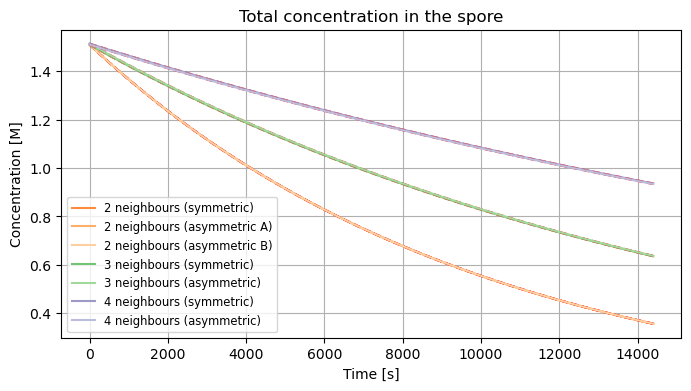

In [17]:
# c_groups = [[vec(c) for c in group] for group in c_groups]
# times_groups = [[vec(t) for t in group] for group in times_groups]
group_labels = [["2 neighbours (symmetric)", "2 neighbours (asymmetric A)", "2 neighbours (asymmetric B)"],
                ["3 neighbours (symmetric)", "3 neighbours (asymmetric)"],
                ["4 neighbours (symmetric)", "4 neighbours (asymmetric)"]]
compare_concentration_evolution_groups(c_groups, times_groups, group_labels; logy=false, fit_exp=true)

The results clearly indicate that the symmetry of the surrounding sphere arrangement does not play a role in their diffusion limiting behaviour. Once again, all cluster numbers cause an exponential decay with a clearly identifiable exponent (exponential fits plotted with dashed lines).

## 6. Functional relationship between spore coverage and decay exponent

With the important recognition that only the number of adjacent neighbours affects the concentration decay and that the fucntion of this decay is exponential, full and half cluster sizes of all available integers are simulated. The coverage measure and the resulting decay are recorded to obtain a functional relationship between them.

In [ ]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 128
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# Simulation parameters (neighbours, trim)
param_set = [(2, true), (2, false), (3, false), (4, false), (6, true), (6, false), (8, false), (12, false)]

coverages = [0.0]
exponents = []

# Run single spore simulation
spore_center_idx = (N ÷ 2, N ÷ 2, N ÷ 2)
c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, [spore_center_idx], spore_rad, t_max;
                                                                                                    D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                    crank_nicolson=false, abs_bndry=true)
fit = exp_fit(times_numerical, c_numerical)
push!(exponents, fit[2])

# Run spore cluster simulations
for (n_nbrs, trim) in param_set
    println("Running simulation with $(n_nbrs) neighbours and trim: $(trim)")
    sp_cen_indices = setup_spore_cluster(n_nbrs, N, spore_rad / dx + 0.5, trim) # with safety radius of 0.5
    sp_cen_coords = [(i[1] * dx, i[2] * dx, i[3] * dx) for i in sp_cen_indices]
    c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, sp_cen_indices, spore_rad, t_max;
                                                                                                        D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                        crank_nicolson=false, abs_bndry=true)
    # push!(c_group, vec(c_numerical_ms))
    # push!(times_group, vec(times_numerical_ms))
    push!(coverages, measure_coverage(sp_cen_coords[1], sp_cen_coords[2:end], spore_rad))
    fit = exp_fit(times_numerical, c_numerical)
    push!(exponents, fit[2])
end

Using D = 600, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 6.688382673779544e-5, Dcw*dt/dx2 = 3.344191486004655e-5
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
Frame 1 saved.
Frame 2 saved.
Frame 3 saved.
Frame 4 saved.
Frame 5 saved.
Frame 6 saved.
Frame 7 saved.
Frame 8 saved.
Frame 9 saved.
Frame 10 saved.
Frame 11 saved.
Frame 12 saved.
Frame 13 saved.
Frame 14 saved.
Frame 15 saved.
Frame 16 saved.
Frame 17 saved.
Frame 18 saved.
Frame 19 saved.
Frame 20 saved.
Frame 21 saved.
Frame 22 saved.
Frame 23 saved.
Frame 24 saved.
Frame 25 saved.
Frame 26 saved.
Frame 27 saved.
Frame 28 saved.
Frame 29 saved.
Frame 30 saved.
Frame 31 saved.
Frame 32 saved.
Frame 33 saved.
Frame 34 saved.
Frame 35 saved.
Frame 36 saved.
Frame 37 saved.
Frame 38 saved.
Frame 39 saved.
Frame 40 saved.
Frame 41 saved.
Frame 42 saved.
Frame 43 saved.
Frame 44 saved.
Frame 45 saved.
Frame 46 saved

It is known that, given fast diffusion in the surrounding medium, the concentration in an uncovered spore decreases exponentially as $\sim e^{-t/\tau}$. A logical assumption is that the presence of adjacent spores modulate this decay with a factor $a$ as $\sim e^{-at/\tau}$. To neutralise the role of $\tau$ in the analysis, the measured exponents are divided by $-\tau$ in order to obtain the sole contribution of the spore coverage.

Fitted power: (0.03795789703252093, -0.7498401824933918)


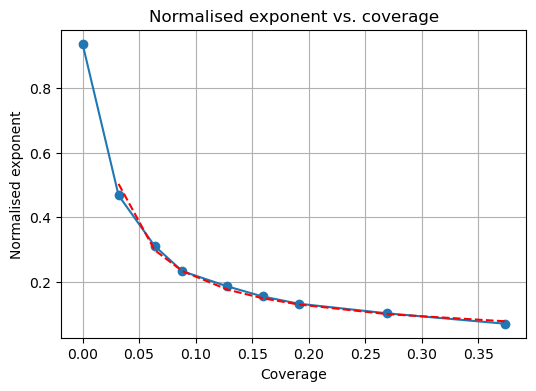

In [74]:
# Normalise exponents with tau
V_spore = 4/3 * π * spore_rad^3
A_spore = 4 * π * spore_rad^2
tau = Ps_fit * A_spore / V_spore
exp_norm = -exponents ./ tau

plot_functional_relationship(coverages, exp_norm, ["Coverage", "Normalised exponent"], "Normalised exponent vs. coverage", fit="pow")

The relationship between coverage and decay exponent exhibits a power-law, with a fitted exponent of approximately $3/4$. The relationship $a\sim Q^{3/4}$ can be related to the decrease in concentration at the spore, which appears to be

$$
\begin{equation}
c{(t)}=c_0e^{-\frac{t}{\tau}Q^{3/4}}.
\end{equation}
$$

## 7. Role of neighbour distance

All experiments so far looked into directly adjacent neighbour spores. As the coverage measure also accounts for the distance between neighbour surfaces, a relevant question is how much the blocking effect diminishes with distance. To examine this, two experiments are conducted - one with a single neighbour spore and one with a fully packed 12-neighbour configuration. In both cases, the centre-to-centre distance between the central spore and the neighbours is gradually increased from $2R$ to $5R$ on a lattice of size $256\times0.2 \mu m$.

In [ ]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 256
dx = 0.2 # 1 cell is 0.20 um long

# High resolution (implicit)
dt = 0.05
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 10

# Simulation parameters (neighbours, trim)
param_set = [(2, true), (12, false)]
distances = collect(1:0.25:2.5) * spore_diameter

# Run spore cluster simulations
c_groups = []
c_frame_groups = []
times_groups = []
coverage_groups = []
exponent_groups = []
for (n_nbrs, trim) in param_set
    c_group = []
    c_frame_group = []
    times_group = []
    coverage_group = []
    exponent_group = []
    for dist in distances
        println("Running simulation with $(n_nbrs) neighbours and trim: $(trim), at distance: $(dist)")
        
        sp_cen_indices = setup_spore_cluster(n_nbrs, N, 0.5 * dist / dx + 0.5, trim) # with safety radius of 0.5
        sp_cen_coords = [(i[1] * dx, i[2] * dx, i[3] * dx) for i in sp_cen_indices]
        push!(coverage_group, measure_coverage(sp_cen_coords[1], sp_cen_coords[2:end], spore_rad))

        c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(copy(c_init), c0_cw, sp_cen_indices, spore_rad, t_max;
                                                                                                            D=D, Db=Db, dt=dt, dx=dx, n_save_frames=n_save_frames,
                                                                                                            crank_nicolson=false, abs_bndry=true)
        push!(c_group, vec(c_numerical))
        push!(c_frame_group, c_frames)
        push!(times_group, vec(times_numerical))
        fit = exp_fit(times_numerical, c_numerical)
        push!(exponent_group, fit[2])
    end
    push!(c_groups, vec(c_group))
    push!(c_frame_groups, c_frame_group)
    push!(times_groups, vec(times_group))
    push!(coverage_groups, coverage_group)
    push!(exponent_groups, exponent_group)
end

Running simulation with 2 neighbours and trim: true, at distance: 5.0
Using D = 600, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 6.688382673779544e-5, Dcw*dt/dx2 = 3.344191486004655e-5
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.


(11,)


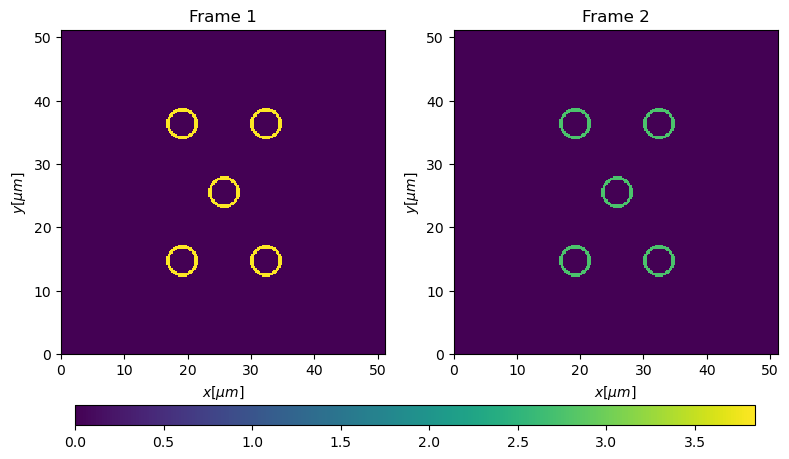

In [21]:
dist_idx=4
cluster_idx=2
println(size(times_groups[cluster_idx][dist_idx]))
plot_concentration_lattice(c_frame_groups[cluster_idx][dist_idx], dx; times=times_groups[cluster_idx][dist_idx])

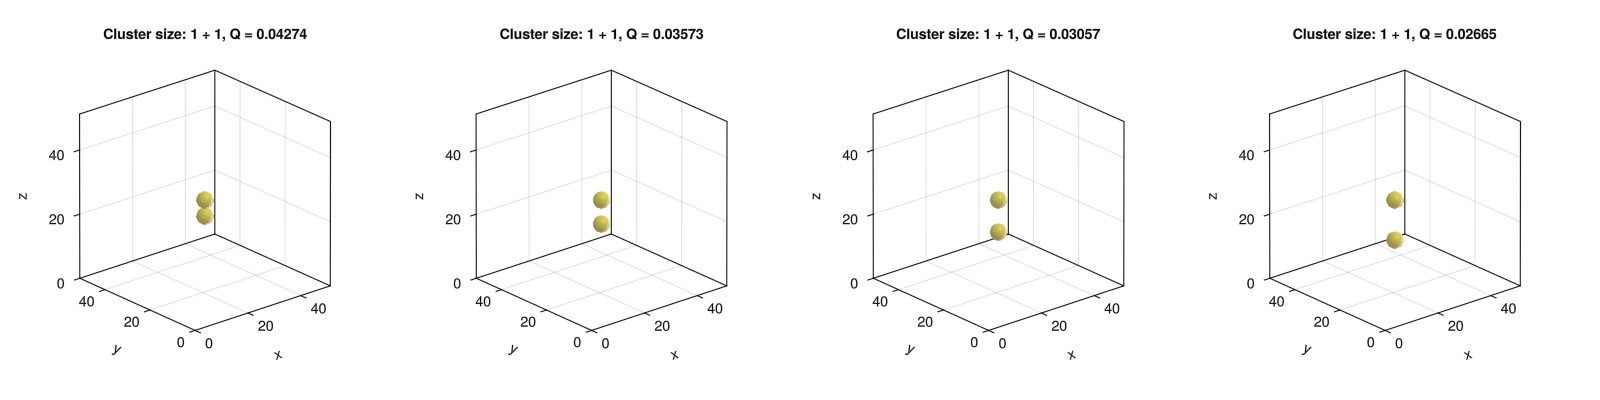

GLMakie.Screen(...)

In [4]:
n_nbrs = [2 for dist in distances]
plot_spore_clusters(n_nbrs, spore_rad, N*dx, length(distances); cut_half=true, spore_spacings=distances)

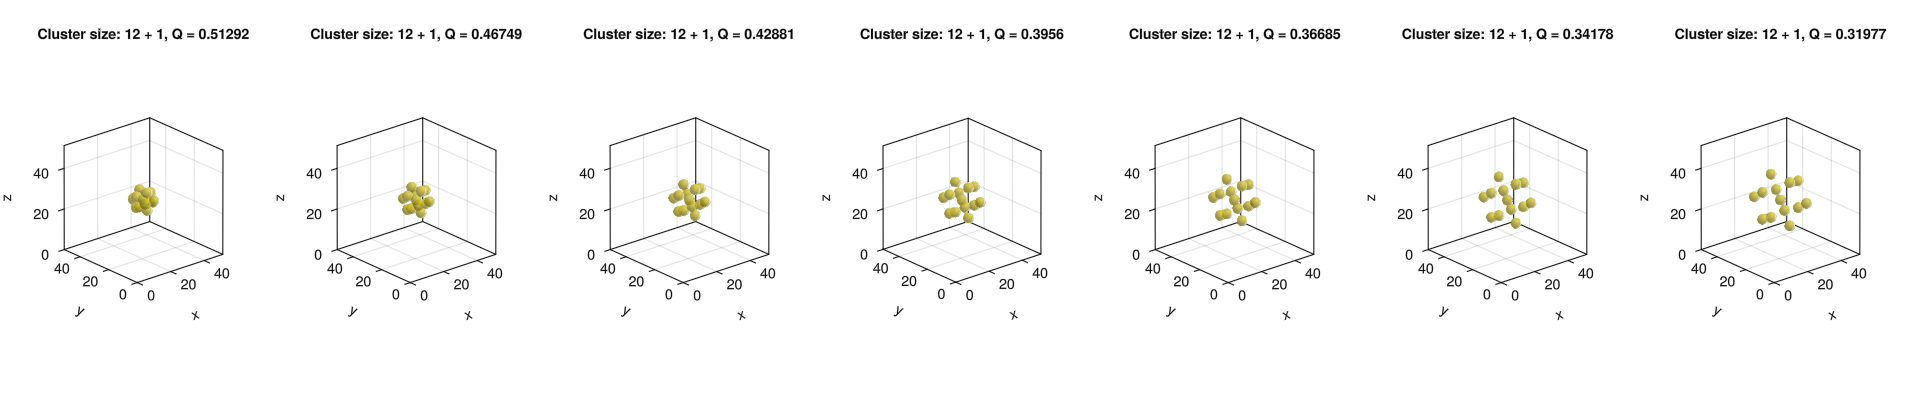

GLMakie.Screen(...)

In [18]:
n_nbrs = [12 for dist in distances]
plot_spore_clusters(n_nbrs, spore_rad, N*dx, length(distances); spore_spacings=distances)

["2 neighbours, distance 5.0", "2 neighbours, distance 7.5", "2 neighbours, distance 10.0", "2 neighbours, distance 12.5"]
2 neighbours, distance 5.0
Fitted exponential: (1.5099148439389345, -0.00015019454289725922)
2 neighbours, distance 7.5
Fitted exponential: (1.509914364286478, -0.00015019624951804702)
2 neighbours, distance 10.0
Fitted exponential: (1.5099213717761109, -0.00015019904194567033)
2 neighbours, distance 12.5
Fitted exponential: (1.5099139192903213, -0.0001501958242505168)
["12 neighbours, distance 5.0", "12 neighbours, distance 7.5", "12 neighbours, distance 10.0", "12 neighbours, distance 12.5"]
12 neighbours, distance 5.0
Fitted exponential: (1.5097721338519992, -2.3071870304045773e-5)
12 neighbours, distance 7.5
Fitted exponential: (1.5098116531966348, -2.3081960453081807e-5)
12 neighbours, distance 10.0
Fitted exponential: (1.5097847404263576, -2.3084978926300757e-5)
12 neighbours, distance 12.5
Fitted exponential: (1.5098411032654362, -2.3069925346454052e-5)


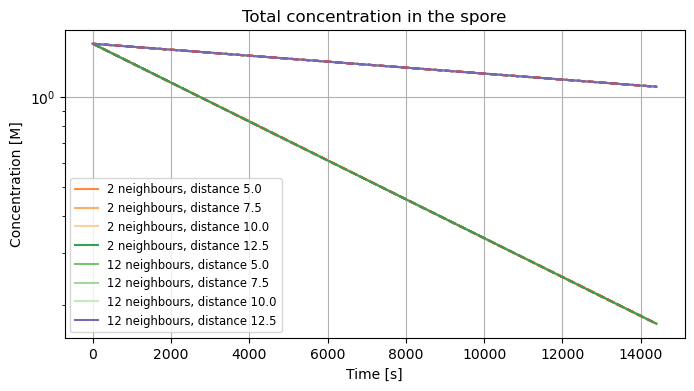

In [ ]:
# c_groups_vec = [[vec(c) for c in group] for group in c_groups]
# times_groups_vec = [[vec(t) for t in group] for group in times_groups]
group_labels = [["2 neighbours, distance $dist" for dist in distances], ["12 neighbours, distance $dist" for dist in distances]]	
compare_concentration_evolution_groups(c_groups_vec, times_groups_vec, group_labels; logy=true, fit_exp=true)
# compare_concentration_evolution_groups([c_groups_vec[1][1:3]], [times_groups_vec[1][1:3]], [group_labels[1][1:3]]; logy=true, fit_exp=true)

[0.07187142544261796, 0.07192877525372715, 0.07190779503599845, 0.0719120155274905, 0.07191550012726478, 0.07191152744016123, 0.07187379146494415]


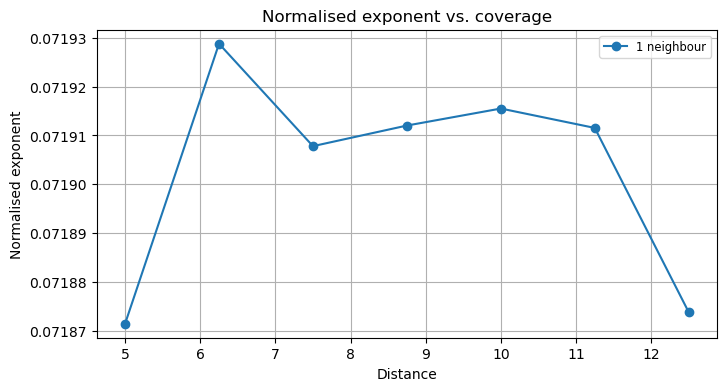

In [ ]:
# Normalise exponents with tau
V_spore = 4/3 * π * spore_rad^3
A_spore = 4 * π * spore_rad^2
tau = Ps_fit * A_spore / V_spore
exp_norm_groups = [-exponent_group ./ tau for exponent_group in exponent_groups]

# compare_functional_relationships(coverage_groups, exp_norm_groups, ["Coverage", "Normalised exponent"], ["1 neighbour", "12 neighbours"], "Normalised exponent vs. coverage", fit="pow")
compare_functional_relationships([distances], [exp_norm_groups[2]], ["Distance", "Normalised exponent"], ["1 neighbour"], "Normalised exponent vs. distance")

Any[0.37377910675557247, 0.07287791114166352, 0.012512177695163244, 0.0025137329720163774, 0.0006022701269291884, 0.0001216341668635678, 3.088839207629153e-5]


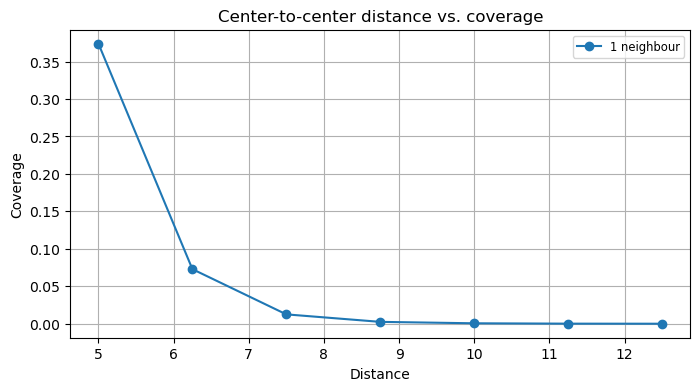

In [69]:
compare_functional_relationships([distances], [coverage_groups[2]], ["Distance", "Coverage"], ["1 neighbour"], "Center-to-center distance vs. coverage")

The results show a barely distinguishable change in the decay exponent with increasing distance. To verify that this is not due to a numerical error in the implementation of the implicit solution method, the two extreme distances are also simulated using an explicit scheme. The permeation constant is thereby increased to avoid known cancellation errors with the forward Euler method. An implicit method simulation is run with the same permeation constant for comparison. This is performed for a short time frame of $t_{\textrm{max}}=1$ second.

In [ ]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.001 # microns/s
t_max = 1#14400#3600 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
spore_rad = spore_diameter / 2.0
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# Lattice parameters
N = 256
dx = 0.2 # 1 cell is 0.20 um long

# High resolution simulation parameters
dt_im = 0.05
dt_ex = 0.00001
Db = Ps_fit * dx / K # compute diffusion coefficient from permeability
c_init = zeros(Float64, N, N, N)

n_save_frames = 100

# Simulation parameters (neighbours, trim)
param_set = [(2, true), (12, false)]
distances = vec([1, 2.5]) * spore_diameter

# Run spore cluster simulations
coverage_groups = []

c_groups_ex = []
c_frame_groups_ex = []
times_groups_ex = []
exponent_groups_ex = []

c_groups_im = []
c_frame_groups_im = []
times_groups_im = []
exponent_groups_im = []

for (i, (n_nbrs, trim)) in enumerate(param_set)

    coverage_group = []
    
    c_group_ex = []
    c_frame_group_ex = []
    times_group_ex = []
    exponent_group_ex = []

    c_group_im = []
    c_frame_group_im = []
    times_group_im = []
    exponent_group_im = []
    
    for (j, dist) in enumerate(distances)
        println("Running simulation with $(n_nbrs) neighbours and trim: $(trim), at distance: $(dist)")
        sp_cen_indices = setup_spore_cluster(n_nbrs, N, 0.5 * dist / dx + 0.5, trim) # with safety radius of 0.5
        sp_cen_coords = [(i[1] * dx, i[2] * dx, i[3] * dx) for i in sp_cen_indices]
        push!(coverage_group, measure_coverage(sp_cen_coords[1], sp_cen_coords[2:end], spore_rad))

        # Explicit
        c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res!(copy(c_init), c0_cw, sp_cen_indices, spore_rad, t_max;
                                                                                                    D=D, Db=Db, dt=dt_ex, dx=dx, n_save_frames=n_save_frames)
        push!(c_group_ex, c_numerical)
        push!(c_frame_group_ex, c_frames)
        push!(times_group_ex, times_numerical)
        fit = exp_fit(times_numerical, c_numerical)
        push!(exponent_group_ex, fit[2])

        # Implicit
        c_frames, c_numerical, times_numerical, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(copy(c_init), c0_cw, sp_cen_indices, spore_rad, t_max;
                                                                                                            D=D, Db=Db, dt=dt_im, dx=dx, n_save_frames=n_save_frames,
                                                                                                            crank_nicolson=false, abs_bndry=true)
        push!(c_group_im, c_numerical)
        push!(c_frame_group_im, c_frames)
        push!(times_group_im, times_numerical)
        fit = exp_fit(times_numerical, c_numerical)
        push!(exponent_group_im, fit[2])
    end
    push!(coverage_groups, coverage_group)

    push!(c_groups_ex, c_group_ex)
    push!(c_frame_groups_ex, c_frame_group_ex)
    push!(times_groups_ex, times_group_ex)
    push!(exponent_groups_ex, exponent_group_ex)

    push!(c_groups_im, c_group_im)
    push!(c_frame_groups_im, c_frame_group_im)
    push!(times_groups_im, times_group_im)
    push!(exponent_groups_im, exponent_group_im)
end

Running simulation with 2 neighbours and trim: true, at distance: 5.0
Using D = 600, Db = 0.0002, Dcw = 0.00010000001666666945
D*dt/dx2 = 0.14999999999999997, Db*dt/dx2 = 4.999999999999999e-8, Dcw*dt/dx2 = 2.5000004166667358e-8
Spore radius in lattice units: 12.5
Concentrations initialised.
Ideal cell wall volume: 26.657460863260585
Discretised cell wall volume: 65.24800000000002
Ideal spore volume: 65.44984694978736
Discretised spore volume: 131.47200000000004
Storage arrays allocated.
Frame 100 saved.Using D = 600, Db = 0.0002, Dcw = 0.00010000001666666945
D*dt/dx2 = 749.9999999999999, Db*dt/dx2 = 0.00024999999999999995, Dcw*dt/dx2 = 0.0001250000208333368
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Correcting number of frames to save.
Storage arrays allocated.
3.8399999141693115
Frame 1 saved.3.8398921489715576
Frame 2 saved.3.839784622192383
Frame 3 saved.3.839676856994629
Frame 4 saved.3.839569091796875
Frame 5 saved.3.839461326599121
Frame 6 sa

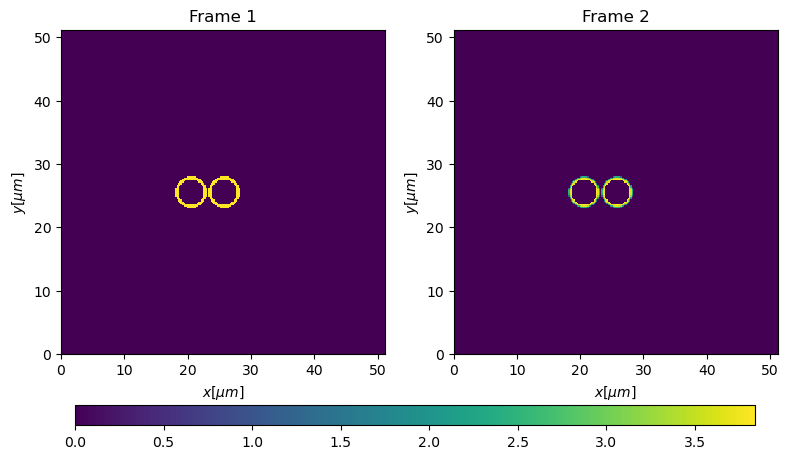

In [5]:
dist_idx=1
cluster_idx=1
plot_concentration_lattice(c_frame_groups_ex[cluster_idx][dist_idx], dx; times=times_groups_ex[cluster_idx][dist_idx])

In [64]:
c_groups_im[1]

2-element Vector{Any}:
 [1.5099232959329494, 1.5100512624700906, 1.5101762290591088, 1.5102980082032451, 1.510416599902501, 1.5105320979052541, 1.5106444084631259, 1.5107535315761167, 1.5108594672442264, 1.5109623092158342  …  1.5111588995662992, 1.5112525541967787, 1.5113433026275132, 1.5114311448585034, 1.5115160808897488, 1.5115982044696286, 1.5116776093465212, 1.5117542955204273, 1.511828450488104, 1.511899886752794]
 [1.5099232959329494, 1.5100512624700906, 1.5101762290591088, 1.5102980082032451, 1.510416599902501, 1.5105320979052541, 1.5106445022115047, 1.510753625324496, 1.5108595609926054, 1.5109624029642128  …  1.5111589933146783, 1.5112526479451573, 1.5113433963758924, 1.5114312386068824, 1.5115161746381278, 1.5115982982180072, 1.5116777030949, 1.5117543892688063, 1.511828450488104, 1.511899886752794]

(2,)
["2 neighbours, distance 5.0, (implicit)", "2 neighbours, distance 12.5, (implicit)"]
2 neighbours, distance 5.0, (implicit)
Fitted exponential: (1.510020455587073, 0.001305625213081014)
2 neighbours, distance 12.5, (implicit)
Fitted exponential: (1.5100204819588818, 0.0013056670885185915)
["12 neighbours, distance 5.0, (implicit)", "12 neighbours, distance 12.5, (implicit)"]
12 neighbours, distance 5.0, (implicit)
Fitted exponential: (1.5099396664312255, 0.00019691020768175014)
12 neighbours, distance 12.5, (implicit)
Fitted exponential: (1.5099397743773226, 0.00019679088127134417)
["2 neighbours, distance 5.0, (explicit)", "2 neighbours, distance 12.5, (explicit)"]
2 neighbours, distance 5.0, (explicit)
Fitted exponential: (1.4972701428679094, -0.19765611644947895)
2 neighbours, distance 12.5, (explicit)
Fitted exponential: (1.497264783995258, -0.19769159560583077)
["12 neighbours, distance 5.0, (explicit)", "12 neighbours, distance 12.5, (explicit)"]
12 neighbours, distance 5.0

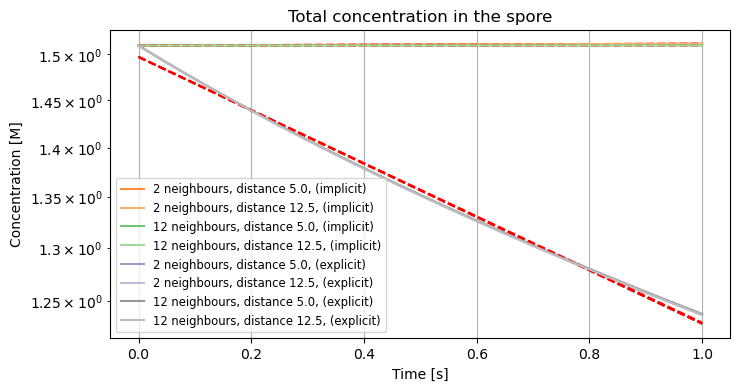

In [6]:
# matplotlib.pyplot.close()
tags = ["implicit", "explicit"]
c_groups = [[[vec(c) for c in group] for group in c_groups_im]; [[vec(c) for c in group] for group in c_groups_ex]]
times_groups = [[[vec(t) for t in group] for group in times_groups_im]; [[vec(t) for t in group] for group in times_groups_ex]]
group_labels = [["2 neighbours, distance $dist, (implicit)" for dist in distances], ["12 neighbours, distance $dist, (implicit)" for dist in distances],
                ["2 neighbours, distance $dist, (explicit)" for dist in distances], ["12 neighbours, distance $dist, (explicit)" for dist in distances]]
# group_labels = [["2 neighbours, distance $dist, (implicit)" for dist in distances], ["12 neighbours, distance $dist, (implicit)" for dist in distances]]
# println(c_groups_im)
c_groups_ex_vec = [[vec(c) for c in group] for group in c_groups_im]
times_groups_ex_vec = [[vec(t) for t in group] for group in times_groups_im]
# times_groups_ex_vec = [vec(times_groups_ex[i, :, :]) for i in 1:size(times_groups_ex)[1]]
println(size(c_groups_ex_vec[1]))
compare_concentration_evolution_groups(c_groups, times_groups, group_labels; logy=true, fit_exp=true)
# compare_concentration_evolution_groups(c_groups_ex_vec, times_groups_ex_vec; logy=false, fit_exp=true)